
--- 
### <center> Metrics and Results Achieved</center>

---

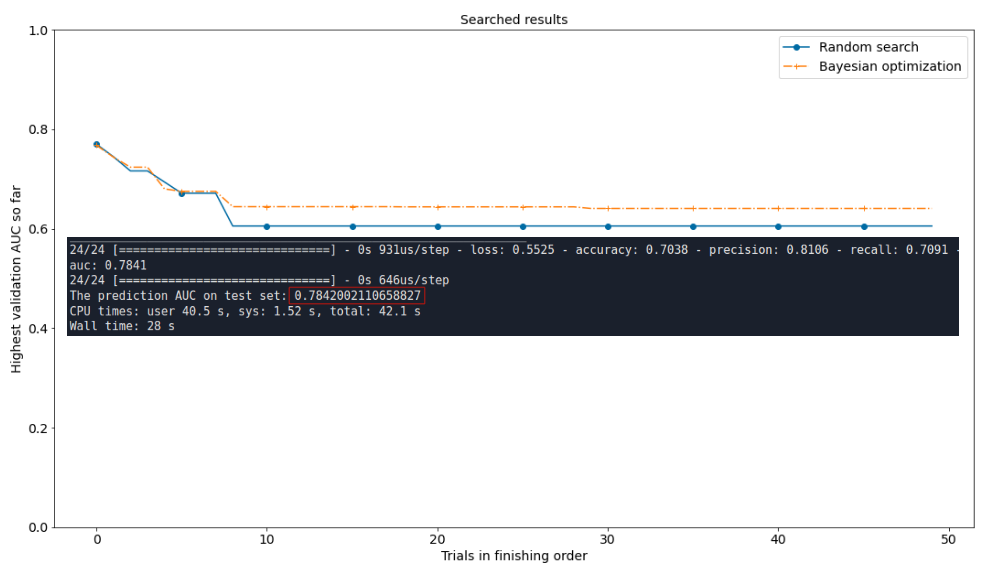


Em síntese, os resultados apresentados confirmar que temos um modelo que demostrar **resultados plausíveis** de acordo com dados utilizados, ou seja, *“Todos os modelos estão errados, mas alguns modelos são úteis.”* - George Box. Portanto, o pesquisador do projeto orienta aos executivos **nível C** como: CEO, CMO,CTO, CFO etc., e o novo Chief Data Officer (CDO) que realiza o deploy do modelo.


De acordo com esses resultados alcançáveis,esse modelo atinge AUC em teste **78%** significa que há 78% de chance de que o modelo seja capaz de distinguir entre **classe positiva** "1s" e **classe negativa "0s"**.Lembre-se que, queremos o modelo quão bem ele consegue realizar a predição em novos dados.

É importante ressaltar que quanto maior o valor da AUC, mais eficaz é o classificador. Uma AUC de 1 indica um classificador perfeito: classifica todos os **1s** corretamente, e não classifica erroneamente nenhum **0s** como **1s**.
    

### Importing Necessary Modules and Functions

In [5]:
# Importing libraries needed for Operating System Manipulation in Python
import os, sys
sys.path.append("..")
from pathlib import Path
from platform import python_version
from packaging import version

# Import libraries TensorFlow e Keras
import tensorflow as tf
import keras_tuner as kt

assert sys.version_info >= (3, 7)
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Para ocultar Future Warnings.
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [22]:
# Importing libraries AutoML
#import automl
from automl import  tuner, search_method, search_algorithm 
from logs.tensorboard import name_logdir
from tensorflow.keras.utils import plot_model

# Importing library for manipulation and exploration of datasets.
#import modin.pandas as pd
import pandas as pd
import numpy as np
import time

# Importing classes and libraries needed for the data pre-processing step.
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler,Normalizer
)
# Importing libraries for evaluating model performance and splitting 
from sklearn.model_selection import (
    KFold,StratifiedKFold,train_test_split
)
# Importing libraries required to balance the dataset.
from imblearn.over_sampling import BorderlineSMOTE

# Importing classes to calculate predictive model evaluation metrics.
from sklearn.metrics import roc_auc_score

# For Graph Rendering using matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as m

# Formatting the graphics output
plt.style.use('tableau-colorblind10')
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

### Load Dataset

In [7]:
%%time
df = pd.read_csv('../data_asset/df.csv')
df.head()

CPU times: user 6.24 ms, sys: 0 ns, total: 6.24 ms
Wall time: 6.38 ms


,loan_amount,value_per_installment,value_future,payment_term,capitalized_interest,months,installment_percent,loan_purpose_radio_tv,loan_purpose_car_used,installment_plans_none,loan_purpose_furniture,loan_purpose_appliances,allow
0,3103.0,1034.333333,3512.596,713.0,409.596,11.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0
1,716.0,716.000000,810.512,341.0,94.512,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4333.0,1083.250000,4540.984,868.0,207.984,4.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0
3,250.0,125.000000,280.000,310.0,30.000,10.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2454.0,1227.000000,2689.584,620.0,235.584,8.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0


### <center> Predictive Modeling</center>


Mediante o exposto nas seções anteriores, analisaremos agora como as inferências são realizadas com  **algoritmos Machine Learning e Deep Learning** para demonstrar seu respectivo valor de **inferência** aos resultados da mineração de dados.

### Train/Validation/Test split

In [8]:
"""A named constant is a name that represents a value that cannot be 
changed during the program's execution."""

# Using Global Constants Defining Named Constants

# Define Standardizer
SCALED_TRAIN = MinMaxScaler()

# Creating the class instance BorderlineSMOTE
BLSM = BorderlineSMOTE(random_state= 130)


In [9]:
# Inputs
X = df.iloc[:,:-1]
# Target
y = (df.iloc[:,-1])

# Train/test data split  
X_train_full, X_test_full, y_train_full, y_test_full =  train_test_split(X,y,test_size=0.20, stratify=y,random_state=42)
X_train, X_valid, y_train, y_valid  = train_test_split(X_train_full,y_train_full,test_size=0.20,random_state=101)

# Aplicando a transformação de Oversampling: (super-amostragem) no conjunto de dados de train usando BorderSMOTE
X_train_blsm_full, y_train_blsm_full = BLSM.fit_resample(X_train_full,y_train_full)
X_train_blsm, y_train_blsm = BLSM.fit_resample(X_train,y_train) # validation

# Apply Transform generalization
X_train_min_max_full = SCALED_TRAIN.fit_transform(X_train_full)
X_train_min_max      = SCALED_TRAIN.fit_transform(X_train) # validation
X_test_min_max_full  = SCALED_TRAIN.transform(X_test_full)
X_valid_min_max      = SCALED_TRAIN.transform(X_valid)

# Apply Transform generalization with Class Balancing using algorithm BoreLineSMOTE
X_train_blsm_full_min_max = pd.DataFrame(SCALED_TRAIN.fit_transform(X_train_blsm_full), columns=X_train_blsm_full.columns)
X_train_blsm_min_max      = pd.DataFrame(SCALED_TRAIN.fit_transform(X_train_blsm), columns=X_train_blsm.columns) # validation

print(f'Original dataset:     {X_train_min_max_full.shape, X_test_min_max_full.shape, y_train_full.shape}')
print(f'\nValidation dataset: {X_train_min_max.shape, X_valid_min_max.shape, y_train.shape}')

print(f'\nOriginal dataset full with Classes Balancing: {X_train_blsm_full_min_max.shape,y_train_blsm_full.shape}')
print(f'\nValidation dataset with Classes Balancing:    {X_train_blsm_min_max.shape,y_train_blsm.shape}')


Original dataset:     ((3050, 12), (763, 12), (3050,))

Validation dataset: ((2440, 12), (610, 12), (2440,))

Original dataset full with Classes Balancing: ((3956, 12), (3956,))

Validation dataset with Classes Balancing:    ((3172, 12), (3172,))


---

### <center>Preparing the arsenal of AutoML tools</center>

### Evaluate the best discovered model and Predict

> Metrics: Estatísticas para monitorar durante o processo de treinamento e teste, como a precisão de uma tarefa de regressão (este cenário). Estas não afetarão o processo de treinamento, mas serão calculadas e registradas tanto para o treinamento quanto para o conjunto de validação. Esses valores são usados como informações auxiliares para analisar e ajustar o algoritmo projetado.

### Creating a function to evaluate the best discovered model

In [14]:
def fit_and_evaluate(tuner,X_train, y_train, X_test, y_test, name, epochs=None):
    
    # Recover to the best model
    model = tuner.get_best_models(1)[0] # extrair o melhor modelo, ou seja, primeiro modo superior
    
    # Retrain the model, in other words,  Train & eval model
    model.fit(X_train, y_train, epochs= epochs, verbose=0)
    
    # Save  model
    model.save("../model/" f"{name}",overwrite=True)
    
    # Prints a summary of the architecture of the model
    model.summary()

    # Evaluate the model
    model.evaluate(X_test,y_test)
    
    # Use the model for predicitions
    y_pred = model.predict(X_test)
    #test_auc = roc_auc_score(y_test, y_pred)
    print(f"The prediction AUC on test set: {roc_auc_score(y_test, y_pred)}")

### <center>Tune the model architecture</center>

<center><a href="https://keras.io/guides/keras_tuner/getting_started/" target="_bank">Getting started with KerasTuner</a></center>

### Getting started with a random search method

In [11]:
# Ensure reproducibility
search_method.random_seed(102)
"""
Use build-in random search algorithm to tune models 
                        and
Condutst the search process by feeding the training and validation datasets
"""
rt=search_method.random_tuner(X_train_blsm_min_max,y_train_blsm,X_valid_min_max,y_valid,
                              "auc","max","auc",
                              #"accuracy","max","accuracy",
                               max_trials=50,exec_per_trial=1, patience=20, epochs=500, seed= 102,
                               directory="../tuning", proj_name="random_tuner", logdir="random_tuner"
)
"""
rt=search_method.random_tuner(X_train_blsm_full_min_max,y_train_blsm_full,X_test_min_max_full,y_test_full,
                              "auc","max","auc",
                               max_trials=50,exec_per_trial=3, patience=10, epochs=500, seed= 102,
                               directory="../tuning", proj_name="random_tuner", logdir="random_tuner"
                             )

Prints search space summary
rt.search_space_summary(1)
print("="*100)
"""
# Displays the random search  results
#rt.get_best_hyperparameters()[0].values
rt.results_summary(1)

Trial 50 Complete [00h 00m 12s]
auc: 0.7720816135406494

Best auc So Far: 0.7720816135406494
Total elapsed time: 00h 18m 26s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ../tuning/random_tuner
Showing 1 best trials
Trial summary
Hyperparameters:
num_layers: 1
units_0: 224
activation: elu
kernel_initializer: he_normal
dropout_rate: 0.4000000000000001
learning_rate: 0.00020755277053747517
optimizer: adam
batch_size: 32
units_1: 32
units_2: 224
units_3: 32
Score: 0.7720816135406494


### Bayesian optimization search method

In [13]:
# Ensure reproducibility
search_method.random_seed(102)

# Uses the customized Bayesian optimization search oracle
bt=search_method.bo_tuner(X_train_blsm_min_max,y_train_blsm,X_valid_min_max,y_valid,
                          "auc","max","auc",
                          max_trials=50,exec_per_trial=1, patience=20, epochs=500, seed= 102,
                          directory="../tuning", proj_name="bo_tuner", logdir="bo_tuner"
)
# Displays the Bayesian optimization results
bt.results_summary(1)

Trial 50 Complete [00h 00m 15s]
auc: 0.7669385075569153

Best auc So Far: 0.7701858282089233
Total elapsed time: 00h 18m 50s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ../tuning/bo_tuner
Showing 1 best trials
Trial summary
Hyperparameters:
num_layers: 1
units_0: 32
activation: elu
kernel_initializer: he_normal
dropout_rate: 0.2
learning_rate: 0.00015660892440900708
optimizer: adam
batch_size: 32
units_1: 224
units_2: 96
units_3: 224
Score: 0.7701858282089233


### Evaluate the model

In [42]:
%%time
# Function call
random_tuner = fit_and_evaluate(rt,X_train_blsm_full_min_max,y_train_blsm_full,X_test_min_max_full,y_test_full,
                                "random_tuner.h5",300
                               )

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 224)               2912      
                                                                 
 dropout_50 (Dropout)        (None, 224)               0         
                                                                 
 dense_149 (Dense)           (None, 1)                 225       
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 552us/step
The prediction AUC on test set: 0.7889115030906075
CPU times: user 41.9 s, sys: 1.33 s, total: 43.3 s
Wall time: 29.5 s


In [41]:
%%time
# Function call
bo_tuner = fit_and_evaluate(bt,X_train_blsm_full_min_max,y_train_blsm_full,X_test_min_max_full,y_test_full,
                              "bo_tuner.h5",300
                            )

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 32)                416       
                                                                 
 dropout_50 (Dropout)        (None, 32)                0         
                                                                 
 dense_147 (Dense)           (None, 1)                 33        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 646us/step
The prediction AUC on test set: 0.7842002110658827
CPU times: user 40.5 s, sys: 1.52 s, total: 42.1 s
Wall time: 28 s


###  Comparisons between search method of AutoML

Vamos comparar os resultados da pesquisa **Random search com a Bayesian optimization** para
entender melhor os dois métodos. Bem como, extraímos o desempenho da avaliação de todos os
modelos descobertos em ordem. Porém, antes de fazer isso, criaremos duas funções para facilitar a comparação entre esses dois métodos de busca.


### Plot search curves

In [23]:
# Creating functions for plot search curves
def plot_curve(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(18,10))
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def plot_curves(
    x, ys, xlabel, ylabel, title, ymin, ymax, legend, markers, linestyles, markevery=1
):
    plt.figure(figsize=(18,10))
    for i, y in enumerate(ys):
        plt.plot(x, y, marker=markers[i], linestyle=linestyles[i], markevery=markevery)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(ymin, ymax)
    plt.legend(legend)

The total number of different sets of hyperparameter values that were tested: 50 in Random Research
The total number of different sets of hyperparameter values that were tested: 50 in Bayesian optimization


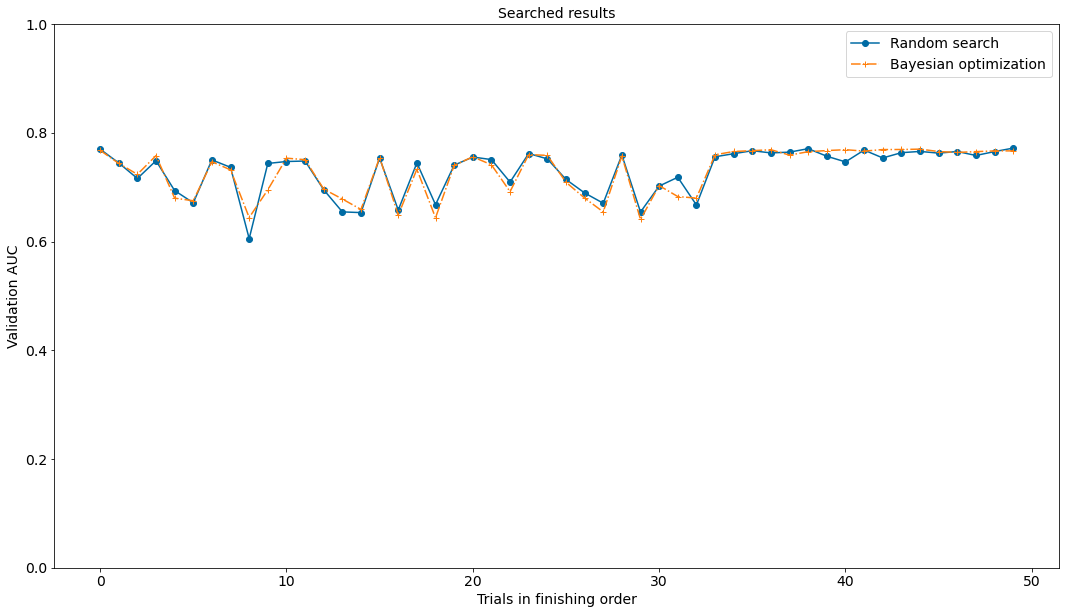

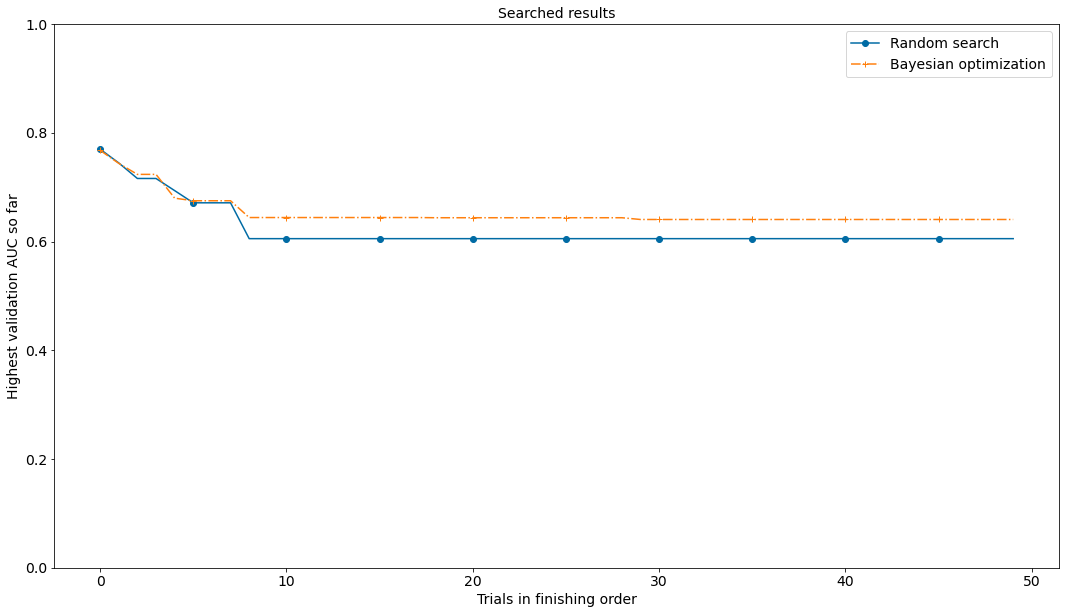

In [45]:
# Capture a lista desempenho para método Random Search e Bayesian optimization
auc_random = [
    rt.oracle.get_trial(trial_id).score for trial_id in rt.oracle.end_order
]
auc_bo = [
    bt.oracle.get_trial(trial_id).score for trial_id in bt.oracle.end_order
]
ids = list(range(len(auc_random)))
ids = list(range(len(auc_bo)))
"""
plot_curve(
    ids, mae_random, "Trials in finishing order", "Validation AUC", "Searched results"
)
plot_curve(
    ids, mae_bo, "Trials in finishing order", "Validation AUC", "Searched results"
)
"""
print(f'The total number of different sets of hyperparameter values that were tested: {len(auc_random)} in Random Research')
print(f'The total number of different sets of hyperparameter values that were tested: {len(auc_random)} in Bayesian optimization')

high_value = float("inf")
high_auc_random = []
for value in auc_random:
    high_value = min(high_value, value)
    high_auc_random.append(high_value)

high_value = float("inf")
high_auc_bo = []
for value in auc_bo:
    high_value = min(high_value, value)
    high_auc_bo.append(high_value)

plot_curves(
    ids,
    [auc_random, auc_bo],
    "Trials in finishing order",
    "Validation AUC",
    "Searched results",
    0,
    1,
    markers=["o", "+"],
    linestyles=["-", "-."],
    legend=["Random search", "Bayesian optimization"],
)
plot_curves(
    ids,
    [high_auc_random, high_auc_bo],
    "Trials in finishing order",
    "Highest validation AUC so far",
    "Searched results",
    0,
    1,
    markers=["o", "+"],
    linestyles=["-", "-."],
    legend=["Random search", "Bayesian optimization"],
    markevery=5,
)